In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os

%pprint
pd.set_option("display.max_rows",10)

Pretty printing has been turned OFF


## 프로젝트: 네이버 영화리뷰 감상분석 도전

### 1) 데이터 준비와 확인

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

2-1) 데이터의 중복 제거 & NaN 결측치 제거   
2-2)  한국어 토크나이저로 토큰화 & 불용어(Stopwords) 제거   
2-3) 사전word_to_index 구성 & 텍스트 스트링을 사전 인덱스 스트링으로 변환해서 X_train, y_train, X_test, y_test, word_to_index 리턴

### 2-1). 데이터의 중복 제거 & NaN 결측치 제거

- 인터넷 리뷰를 간단하게 적다보니 한단어 혹은 한문장으로 리뷰를 표현(굿,good, 쓰레기 등)하는 경우 중복되기가 쉽다. 실제로 4949개의 데이터가 중복되었다. 이렇게 __중복되는 문장을 pandas의 drop_duplicates를 사용해서 없애준다__.(기억하면 좋을 함수..)
- document가 결측치인 데이터도 5건 존재한다. 이것도 삭제해준다.

In [3]:
print(train_data.shape)
double=pd.DataFrame(train_data["document"].value_counts())
print(double.loc[double["document"]>1].sum())
double.loc[double["document"]>1].head(4) 

(150000, 3)
document    4949
dtype: int64


,document
굿,181
good,92
최고,85
쓰레기,79


In [4]:
train_data.loc[train_data["document"].isna()] # label이 결측치인 경우는 없었다.

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [5]:
train_data.drop_duplicates(subset=['document'], inplace=True) # 훈련데이터의 중복되는 document 삭제
train_data = train_data.dropna(how = 'any')                   # 데이터 중에서 하나라도 결측치가 있으면 row 방향으로 데이터 삭제
test_data.drop_duplicates(subset=['document'], inplace=True) # 테스트 데이터의 중복되는 document 삭제
test_data = test_data.dropna(how = 'any')                    # 데이터 중에서 하나라도 결측치가 있으면 row 방향으로 데이터 삭제

In [6]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2-2). 한국어 토크나이저로 토큰화 & 불용어(Stopwords) 제거

In [7]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['을', '한테', '이다' ,'의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 제거
# stopwords "을", 한테, "이다" 추가


X_train = []
for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_test = []
for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
    


- konlpy 라이브러리의 Mecab()의 morphs 메소드는 문장을 형태소 단위(의미를 가지는 요소로서는 더 이상 분석할 수 없는 가장 작은 말의 단위)로 잘라낸다. 
- 형태소 단위로 자른 단어들 중에서 리스트 stopwords에 포함이 안된 단어만 temp_X에 넣어준다. (만일 포함되어있다면 제외)

In [8]:
idx=60
print(train_data["document"][idx])
temp_X=Mecab().morphs(train_data["document"][idx])
print("Mecab()의 morphs 메소드 적용 후:",temp_X)
temp_X=[word for word in temp_X if not word in stopwords]
print("불용어 제거 :",temp_X)

보는내내 그대로 들어맞는 예측 카리스마 없는 악역
Mecab()의 morphs 메소드 적용 후: ['보', '는', '내내', '그대로', '들어맞', '는', '예측', '카리스마', '없', '는', '악역']
불용어 제거 : ['보', '내내', '그대로', '들어맞', '예측', '카리스마', '없', '악역']


- 불용어를 제거한 후에 조사 '는'이 모두 삭제된 것을 볼수 있다.  
- 코드의 stopwords의 리스트['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']에는 주로 조사가 적혀있다. 그래서 [수능 문법의 품사편](https://edu.ingang.go.kr)을 찾아보니까 __'을', '한테', '이다'__ 가 불용어에 추가 되면 좋을 것 같다. 

### 단어 빈도수 EDA 및 불용어 찾기

In [9]:
from collections import Counter
words=[]
for i in X_train+X_test: # X_train과 X_test의 각 문장에 있는 단어들을
    words.extend(i)      # words 리스트에 다 담는다.
counting_words=Counter(words)   # 각 단어가 몇개씩 있는지 카운트해서 
                                # 딕셔너리 형태로 counting_words에 담아둔다 
                                # 단어: 단어수 

In [10]:
freq=[i for i in counting_words.values()]

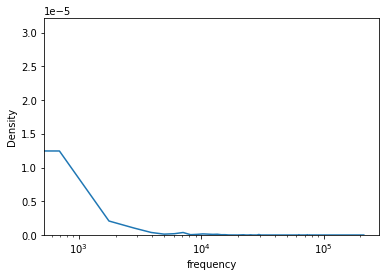

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(freq)
plt.xscale("log")
plt.xlabel("frequency")
plt.show()

단어의 빈도수에 대해서 kdeplot을 그려보았다. x축을 log 스케일로 두고 그렸음에도 불구하고  $10^{4}$ 이후로 매우 긴 꼬리가 있음을 알수 있다. 네이버 영화리뷰에서 매우 많이 쓰여진 적은 수의 단어가 있음을 의미한다. [텍스트 마이닝을 위한 한국어 불용어 목록 연구](https://www.kci.go.kr/kciportal/landing/article.kci?arti_id=ART002390885#none) p.15에서 "불용어 선정을 위해 먼저 대규모의 말뭉치에서 빈도수가 높은 어휘를 선정할 필요가 있다"는 말에 조언을 얻어서 빈도수가 높은 단어를 한번 체크해볼 필요가 있다고 느껴져서 단어빈도수 분포를 그려보았다.. 긴꼬리에 해당하는 (사용 빈도수가 만번을 넘어가는) 단어를 체크해보자

In [12]:
import operator

words=sorted(counting_words.items(),key=operator.itemgetter(1),reverse=True)
# 단어수를 기준으로 내림차순으로 정렬했다.

In [13]:
print(len(words))
words[:60]

61529


[('.', 212367), ('영화', 76907), ('다', 73538), ('고', 62860), ('하', 59283), ('보', 34147), ('..', 30360), ('게', 29753), (',', 29567), ('!', 25686), ('지', 25476), ('있', 22231), ('없', 21199), ('?', 20478), ('좋', 18238), ('나', 16996), ('었', 16251), ('만', 15598), ('는데', 15445), ('너무', 14691), ('봤', 13735), ('안', 13517), ('적', 13493), ('정말', 12997), ('로', 12929), ('음', 12486), ('것', 12393), ('아', 12092), ('네요', 11943), ('재밌', 11732), ('어', 11640), ('같', 11476), ('점', 11458), ('진짜', 11235), ('지만', 11163), ('했', 10883), ('에서', 10756), ('기', 10728), ('네', 10420), ('않', 10279), ('거', 10264), ('았', 10190), ('수', 10002), ('되', 9952), ('면', 9732), ('ㅋㅋ', 9509), ('연기', 9173), ('말', 9144), ('인', 9063), ('주', 8817), ('최고', 8470), ('평점', 8453), ('내', 8427), ('~', 8383), ('이런', 7963), ('던', 7881), ('어요', 7688), ('왜', 7387), ('할', 7362), ('겠', 7266)]

#### 불용어 & 전처리에 필요한 것들...

빈도수가 높은 단어 순위 50위까지 뽑아보았다. 상위 50개의 단어를 뽑으니까 가장 많은 단어 '.'는 212367개이고, 60위 단어인 "할"은 총 7362개가 있다. 등수가 조금만 낮아져도 단어 사용 빈도수가 빠르게 감소한다. 단어 사용수가 많은 단어의 종류를 굳이 부류해보자면  
1. "영화", "연기","평점": 영화리뷰와 관련된 단어
2. '.' ,',,', '!', "?" 등: 문장부호
3. "다", "고", "을", "봤", "좋" 등: 한 글자로 이루어진 단어 
4. "ㅋㅋ": 웃음을 드러내는 약어, 예를들어 'ㅎㅎ'도 비슷한 단어일것 같다.
5. "너무", "정말","진짜","재밌","최고": 수식언(영문법의 부사, 형용사)
6. "지만", "어요","이런","에서","것": 불용어

- 1번: 종류의 단어는 많이 사용되는게 필연적이고 빠져서도 안될 것 같다.   
- 2번: 문장부호도 많이 들어가는게 당연하지만 지금은 감정분석이기 때문에 전처리할때 삭제하는것도 고려해볼 필요가 있을 것 같다. 
- 3번: 한 글자로 이루어진 단어 중에서 '다', '고',"하" 등은 형태소를 나누고 남은 의미없는 단어같다. 반면에 "좋",  성능이 안나올때 빼고 모델을 돌려보는 것을 고려해볼 필요가 있겠다.
- 4번: "ㅋㅋ"는 사람들이 손쉽게 자신의 웃음을 드러낼때 쓰는 표시이다. 감정분류에 사용하면 나쁘지 않을 것 같다. 하지만 ㅋ의 개수가 많아져도 웃는다는 표시인 것은 맞을텐데  "ㅋㅋㅋㅋㅋㅋㅋ"와 "ㅋㅋ"를 다른 단어로 볼것 같다. 그대로 쓸지 아예 "ㅋㅋ", "ㅎㅎ" 를 삭제할지 아니면, 모든 "ㅋ+", "ㅎ+"들을 한개의 ㅋ와 ㅎ로 바꿀 것인지 생각해봐야겠다.
- 5번: 자신의 감정을 더 드러내는 용도로 쓰는 단어이기 때문에 지금처럼 유지되어야 할 단어로 보인다.

가장 간단하게 모델을 만들어보고 여기에서 적은 몇가지 전처리에 필요하다고 생각되는 것들을 하나씩 전처리를 코드를 추가해서 돌려봐야겠다. 

In [14]:
print(X_train[0]) # X_train리스트의 0번째 인덱스
words = np.concatenate(X_train).tolist() 

['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']


In [15]:
words[:15] # words는 X_train의 모든 문장의 단어를 하나의 리스트 안에 넣었다.

['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리', '흠', '.', '..', '포스터', '보고']

### 2-3) 사전word_to_index 구성 & 텍스트 스트링을 사전 인덱스 스트링으로 변환해서 X_train, y_train, X_test, y_test, word_to_index 리턴

In [16]:
counter = Counter(words) 
counter = counter.most_common(10000-4) # words 리스트 안의 단어들 중에서 
                                       # 빈도수가 가장 많은 상위 9996개의 단어만 가져온다. 

vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]  # 앞의 4자리에 special token을 넣어준다. 

word_to_index = {word:index for index, word in enumerate(vocab)}  # vocab에 있는 단어들로 단어사전을 만든다. 
                                                                  # 단어가 key, 빈도수 순위가 value가 된다.
        
def wordlist_to_indexlist(wordlist): # 단어들이 포함된 wordlist를 입력하면 
    return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist] 

            # word_to_index 딕셔너리의 key 안에 word(wordlist 안에 포함된 단어)가 있다면 word_to_index 안의 단어가 들어감
            # word_to_index 딕셔너리의 key 안에 word가 없다면  word_to_index의 key" "(space bar)의 value인 3이 입력된다.
        
X_train = list(map(wordlist_to_indexlist, X_train)) # X_train의 안쪽 리스트에 wordlist_to_indexlist 함수를 적용한다.
X_test = list(map(wordlist_to_indexlist, X_test))   # X_test의 안쪽 리스트에 wordlist_to_indexlist 함수를 적용한다.


#### 2)데이터로더 구성 1,2,3을 모두 거치면 X_train이 다음과 같은 리스트가 된다.

In [17]:
X_train[0]  # 위의 과정을 모두 합치면 

[31, 73, 917, 4, 4, 38, 227, 19, 32, 746]

2) 데이터로더의 구성을 모두 합치면 다음과 같다. 

In [18]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [19]:
import re
# 여러개의 ㅋ를 하나의 ㅋ로 바꿉니다.
def k(x):
    return re.sub(r'["ㅋ"]+', "ㅋ", str(x)) 
def h(x):
    return re.sub(r'["ㅎ"]+', "ㅎ", str(x)) 

In [20]:

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을', '한테', '이다']
# stopwords에 '을', '한테', '이다' 추가

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  #중복 데이터 제거
    train_data = train_data.dropna(how = 'any')   # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    train_data["document"]=train_data["document"].map(lambda x: k(x))
    test_data["document"]=test_data["document"].map(lambda x: k(x))
    train_data["document"]=train_data["document"].map(lambda x: h(x))
    test_data["document"]=test_data["document"].map(lambda x: h(x))
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()   # X_train 문장의 모든 단어들을 모은다.
    counter = Counter(words)                
    counter = counter.most_common(10000-4) # 최다 빈도 단어 9996개를 가져온다. 
                                           # 단어사전의 크기를 10000개로 하겠다는 뜻이다.
                                           # 앞의 0~3까지는 
    
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter] # 토큰화한 단어들을  
    word_to_index = {word:index for index, word in enumerate(vocab)}   # 단어사전을 만든다.
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index["<BOS>"]]+[word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [21]:
X_train[0]# 숫자 벡터가 되었다.

[1, 32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [22]:
index_to_word = {index:word for word, index in word_to_index.items()} # index(단어 순위)가 key이고 단어가 value인 딕셔너리로 바꿈

load_data 함수를 사용해서 만들어진 word_to_index와 index_to_word (단어사전)을 사용해서 문장을 숫자벡터로 encode하고, 숫자벡터를 문장으로 decode하는 함수를 활용해서 앞으로 자연어 데이터를 분석해보고자 한다.

In [23]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
#
# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

위의 네개의 함수 중에서 get_encoded_sentence와 get_decoded_sentence를 한번 테스트해보자

In [24]:
orig_sentence=train_data["document"][500] # 원본 문장
orig_sentence

'나 이거 보고 인형 절대안삼'

In [25]:
print("문장을 숫자벡터로 encode:",get_encoded_sentence(orig_sentence, word_to_index))
print("숫자벡터를 다시 문장으로 decode:",get_decoded_sentence(get_encoded_sentence(orig_sentence, word_to_index), index_to_word))

문장을 숫자벡터로 encode: [1, 20, 118, 549, 2262, 2]
숫자벡터를 다시 문장으로 decode: 나 이거 보고 인형 <UNK>


문장을 숫자벡터로 encode하고 숫자벡터를 다시 문장으로 decode가 잘되는 것을 확인할수 있다. 숫자벡터에서 문장으로 다시 바뀌는 과정에서 원본의 문장의 '절대안삼'이 < UNK > 토큰으로 바뀐 것을 알수 있다. '절대안삼'이라고 하는 단어는 만개의 단어사전 안에 안들어가서 < UNK >로 바뀐모양이다.

### 3) 모델 구성을 위한 데이터 분석 및 가공

#### 3-1) 데이터셋 내 문장 길이 분포
#### 3-2) 적절한 최대 문장 길이 지정
#### 3-3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [26]:
train_len=[len(i) for i in X_train] # 각 문장의 길이를 입력
test_len=[len(i) for i in X_test]

#### 3-1) 데이터셋 내 문장 길이 분포

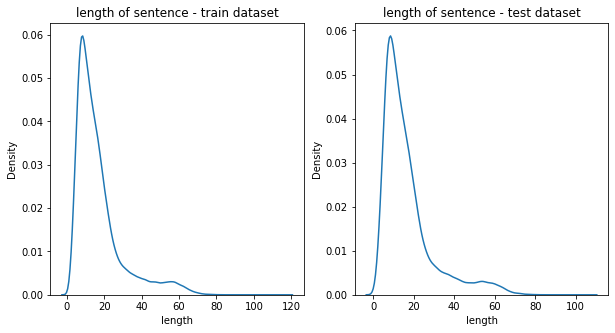

In [27]:
import seaborn as sns

plt.figure(figsize=(10,5))
plt.subplot(121)
sns.kdeplot(train_len)
#plt.hist(train_len, bins=50)
plt.title("length of sentence - train dataset")
plt.xlabel("length")

plt.subplot(122)
#plt.hist(test_len, bins=50)
sns.kdeplot(test_len)
plt.title("length of sentence - test dataset")
plt.xlabel("length")

plt.show()

일단 훈련데이터셋과 시험데이터셋의 문장길이에 대한 kdeplot의 분포는 비슷하다. 즉, train데이터셋에서 결정한 문장길이의 제한을 test dataset에도 비슷한 결과가 나올 것이라는 뜻이다..

In [28]:
df=pd.DataFrame(train_len)
df.columns=["len"] # 문장 최대길이는 117이다.
print(df.len.max())

117


In [29]:
minus,plus,plus_0,eq=[],[],[],[]
for i in range(20,118): 
    df["%d"%i]=i-df["len"]
    minus.append(df.loc[df["%d"%i]<0,"%d"%i].shape[0]) # 주어진 길이보다 길때는  마이너스-> 몇문장을 없애야하는지 체크
    plus_0.append(df.loc[df["%d"%i]>0, "%d"%i].sum())  # 주어진 길이보다 짧을때는 플러스 -> 0을 몇개나 채워넣어야 하는지 입력
    plus.append(df.loc[df["%d"%i]>0, "%d"%i].shape[0]) # 주어진 길이보다 짧을때는 플러스 -> 몇문장이나 0을 채워야하는지 입력
    eq.append(df.loc[df["%d"%i]==0,"%d"%i].shape[0])   # 주어진 길이와 같은 때, -> 몇문장을 save되는지 체크 

In [30]:
df1=pd.DataFrame({"remove_st":minus, 
             "padding_st":plus,
             "padding_0":plus_0,
             "save_st":eq})

In [31]:
df1.head()

,remove_st,padding_st,padding_0,save_st
0,35665,106898,976854,3619
1,32417,110517,1087371,3248
2,29616,113765,1201136,2801
3,27241,116566,1317702,2375
4,25224,118941,1436643,2017


#### 3-2) 적절한 최대 문장 길이 지정: 45

__padding 적용시 추가되는 0의 개수와 지워지는 문장의 trade off관계가 있다고 판단__ 되어서 그래프를 그려보았다.

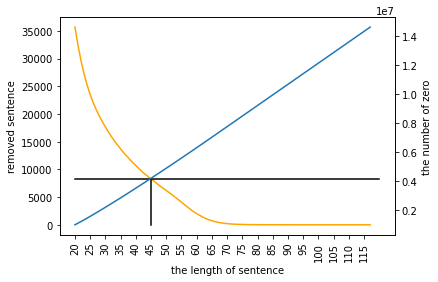

In [32]:
trade_off=45
fig,ax1=plt.subplots()
ax1.plot(list(range(20,118)), df1["remove_st"], color="orange",label="the number of removed sequence")
ax1.plot([trade_off,trade_off],[0, df1["remove_st"][trade_off-20]] ,color="black")
ax1.plot([20,120],[df1["remove_st"][trade_off-20], df1["remove_st"][trade_off-20]], color="black")

plt.ylabel("removed sentence")
plt.xlabel("the length of sentence")
plt.xticks(range(20,120,5), rotation=90)

ax2 = ax1.twinx()
ax2.plot(list(range(20,118)), df1["padding_0"],)
plt.ylabel("the number of zero")

plt.show()

__문장의 최대길이를 늘리면 지워야하는 문장의 개수가 줄어드는 대신에 padding을 만들었을때 0의 개수가 늘어나__ 고,  
__문장의 최대길이를 줄이면 padding을 만들때 0의 개수가 줄어드는 대신에 지워야하는 문장의 개수가 늘어나게__ 된다.
두 그래프가 모두 문장 최대길이에 따라서 선형적으로 늘어나고 줄어들면 그냥 문장의 절반을 선택하면 된다.
하지만 위의 그래프에서 보는 것처럼 __padding을 만들 때의 0의 개수는 문장의 길이에 따라서 선형적으로 증가__ 하지만,   
__지워지는 문장의 개수는 처음엔 빠르게 감소하다가 문장의 길이를 60개로 줄이면 매우 천천히 감소하는 것__ 을 알수 있다.   
그래서 이 둘의 그래프를 그렸고, __두 그래프의 교차점에 위치한 문장길이 45__ 를 선택하기로 했다. 

In [33]:
print("지워지지 않은 문장: ",(1-(df1["remove_st"][25]/len(X_train)))*100, "%")
print("지워진 문장: ",(df1["remove_st"][25]/len(X_train))*100,"%")

지워지지 않은 문장:  94.33172346800563 %
지워진 문장:  5.668276531994363 %


여기서 주어진 task는 감정분석이기 때문에 길이가 45를 넘어가는 문장을 지우지 않고 시도해보아야겠다.

#### 3-3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [34]:
maxlen=45
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=maxlen) # 문장 최대길이 45
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=maxlen) # 문장 최대길이 45


In [35]:
raw_inputs.shape # 45 길이의 146182개의 문장을 갖고 우린 학습을 시킨다.

(146182, 45)

In [36]:
print(raw_inputs[50])
print(get_decoded_sentence(raw_inputs[50], index_to_word))

[   1    5   77 1716    9    2  120   47   16  784 5690    2 2147  500
    7 1023   36    5  454   40   33    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
영화 사람 영혼 을 <UNK> 줄 수 있 군요 거친 <UNK> 잠시 잊 고 동화 같 영화 행복 했 네요 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


정상적으로 패딩이 입혀진 것을 확인할 수 있다.

### 4) 모델 구성 및 validation set 구성

#### 4-1) train dataset과 validation set으로 나누기
#### 4-2) RNN을 사용해서 모델구성
#### 4-3) CNN을 사용해서 모델구성
#### 4-4) GlobalMaxPooling을 사용해서 모델구성


----------------------
#### 4-1) train dataset과 validation set으로 나누기


In [37]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val=train_test_split(raw_inputs, y_train, test_size=0.2, stratify=y_train, random_state=42, shuffle=True)

In [38]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(116945, 45) (116945,)
(29237, 45) (29237,)


#### 4-2) RNN을 사용해서 모델구성

In [39]:
from keras.layers import Dropout
def sent_clf_rnn(num_vocab=10000, dim=200,hidden=8):
    vocab_size = num_vocab
    word_vector_dim = dim  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.LSTM(hidden))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
    model.add(tf.keras.layers.Dense(hidden, activation='relu'))
    model.add(Dropout(0.8)) # 오버피팅 문제 때문에 Dropout을 추가했다.
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    return model

#### 4-3) CNN을 사용해서 모델구성
- 1-D Convolution Neural Network(1-D CNN)
: 1-D으로 문장 전체를 한번에 길이 7짜리 필터로 스캐닝하면서 7단어 이내로 발견되는 특징을 추출해서 문장을 분류한다. RNN 못지 않은 효율을 보여준다.

In [40]:
def sent_clf_cnn(num_vocab=10000, dim=200, filter_num=17,filter_size=7):
    vocab_size = num_vocab
    word_vector_dim = dim  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

    model=tf.keras.Sequential()

    model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.Conv1D(filter_num, filter_size, activation="relu"))
    model.add(tf.keras.layers.MaxPooling1D(5))
    model.add(tf.keras.layers.Conv1D(filter_num,filter_size, activation="relu"))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(Dropout(0.8))  # 오버피팅 문제 때문에 Dropout을 추가했다.
    model.add(tf.keras.layers.Dense(1,activation="sigmoid")) # 최종출력은 긍정 /부정 이진 분류
    model.summary()
    
    return model

#### 4-4) RNN을 사용해서 모델구성

GlobalMaxPooling() 레이어 하나만 사용하는 방법도 있다.
-> 전체 문장에서 가장 중요한 단어 하나만 뽑아내서 긍정과 부정을 나누는 방식

In [41]:
def sent_clf_gmp(num_vocab=10000, dim=200):
    vocab_size = num_vocab
    word_vector_dim = dim  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

    model=tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(Dropout(0.8)) # 오버피팅 문제 때문에 Dropout을 추가했다.
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.summary()
    return model

### 5) 모델 훈련 개시
#### 5-1) RNN을 사용한 감정분석 모델
#### 5-2) CNN을 사용한 감정분석 모델
#### 5-3) GlobalMaxPooling을 사용한 감정분석 모델


### 5-1)RNN을 사용한 감정분석 모델

In [42]:
tf.random.set_seed(100) # 모델의 weight의 가중치를 고정시킨다
rnn_model=sent_clf_rnn(dim=1200)
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

rnn_history = rnn_model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 1200)        12000000  
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 38688     
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 12,038,769
Trainable params: 12,038,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
229/229 [==============================] - 7s 19ms/step - loss: 0.6918 - accuracy: 0.5051 - val_los

### 5-2) CNN을 사용한 감정분석 모델

In [43]:
tf.random.set_seed(100) # 모델의 weight의 가중치를 고정시킨다

cnn_model=sent_clf_cnn(dim=1200)
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_history = cnn_model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 1200)        12000000  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 17)          142817    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 17)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 17)          2040      
_________________________________________________________________
global_max_pooling1d (Global (None, 17)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 144       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                

### 5-3) GlobalMaxPooling을 사용한 감정분석 모델

In [44]:
tf.random.set_seed(100) # 모델의 weight의 가중치를 고정시킨다
gmp_model=sent_clf_gmp(dim=1200)
gmp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gmp_history = gmp_model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 1200)        12000000  
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 9608      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 12,009,617
Trainable params: 12,009,617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
229/229 [==============================] - 4s 16ms/step - loss: 0.6534 - accuracy: 0.5651 - val_l

In [45]:
rnn_df=pd.DataFrame(rnn_history.history)
cnn_df=pd.DataFrame(cnn_history.history)
gmp_df=pd.DataFrame(gmp_history.history)

In [46]:
rnn_df.head(2)

,loss,accuracy,val_loss,val_accuracy
0,0.691820,0.505135,0.687632,0.519445
1,0.634173,0.610749,0.471574,0.829223


### 6) Loss, Accuracy 그래프 시각화

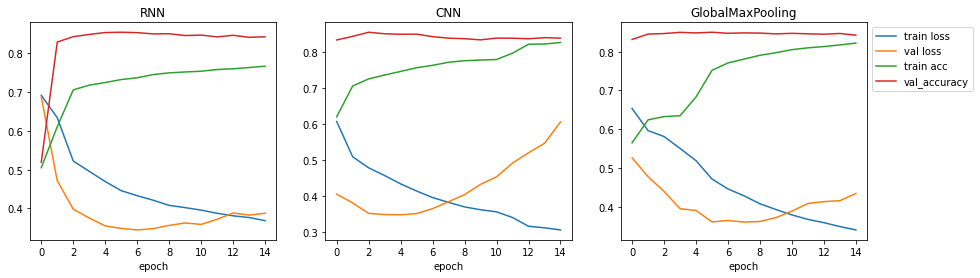

In [47]:
plt.figure(figsize=(15,4))
for i,(m,t) in enumerate(zip([rnn_df,cnn_df,gmp_df],["RNN","CNN","GlobalMaxPooling"])):
    plt.subplot(1,3,i+1)
    plt.plot(m["loss"], label="train loss")
    plt.plot(m["val_loss"], label="val loss")

    plt.plot(m["accuracy"],label="train acc")
    plt.plot(m["val_accuracy"], label="val_accuracy")
    plt.title(t)
    plt.xlabel("epoch")

plt.legend(bbox_to_anchor=[1,1])
plt.show()

In [48]:
tf.random.set_seed(100)

rnn_model=sent_clf_rnn(num_vocab=10000, dim=600,hidden=8)
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=6

rnn_history = rnn_model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results=rnn_model.evaluate(X_test, y_test)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 600)         6000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 19488     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 6,019,569
Trainable params: 6,019,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
229/229 [==============================] - 4s 12ms/step - loss: 0.6905 - accuracy: 0.5080 - val_loss

In [49]:
print(results)

[0.3482793867588043, 0.8517810106277466]


## 루브릭 평가 85% 이상 달성했다.

- RNN은 epoch 10 이상이 넘어가면서 오버피팅이 일어나게 되고 , CNN와 GlobalMaxPooling는 epoch 4가 넘어가면서 오버피팅이 일어난 것을 확인 할수 있었다.
- CNN과 GlobalMaxPooling은 처음에 빠르게 학습이 이뤄진 후(epoch 1에서 이미 validation accuracy가 0.8을 넘어갔다.) epoch이 늘어나면서 loss는 증가하고 accuracy는 떨어지는 학습곡선을 그리는 것을 확인할 수 있다. RNN에 비해서 학습을 적게 시키는게 좋은 것 같다.

- 다만 dropout도 쓰고 튜닝도 하고 여러가지 시도를 했지만 가장 높은 accuracy가 0.85 부근을 맴돌았다.

### 7) 학습된 Embedding 레이어 분석

In [50]:
embedding_layer = rnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 600)


In [51]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(10000-4, 600))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = rnn_model.get_weights()[0]
for i in range(4,10000):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [52]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)


In [53]:
vector = word_vectors['사랑']
vector

array([ 3.81611846e-02,  2.34245956e-02,  8.00138935e-02, -6.98478818e-02,
        5.23886830e-02, -2.36408645e-03,  9.16719716e-03,  1.04825860e-02,
        5.52993361e-03,  7.37933721e-03,  9.42501798e-02, -5.63070215e-02,
        7.95156732e-02,  7.16196522e-02,  4.19154949e-02, -4.33636270e-02,
        2.99331290e-03, -8.39370340e-02,  5.07827103e-02, -7.96854123e-02,
        6.36261627e-02, -3.19762081e-02, -1.39307464e-02, -6.31766692e-02,
       -8.91661346e-02,  2.80747097e-02, -8.92098397e-02, -8.52435455e-03,
       -2.52675340e-02, -3.98830958e-02, -2.65746471e-02,  1.19561739e-01,
        4.43221405e-02, -1.70488954e-02, -4.47779708e-02,  6.16375953e-02,
        6.64233044e-02,  1.45663619e-02,  1.16393408e-02,  2.05274764e-03,
       -2.11139699e-03,  6.93608299e-02, -9.06649455e-02, -9.86658782e-02,
        1.00258544e-01, -1.37566803e-02, -4.67380174e-02,  1.61022767e-02,
       -8.68714526e-02, -1.07887819e-01,  8.00715685e-02, -2.89835129e-02,
       -9.23628509e-02,  

단어의 유사도가 높은 단어를 가져왔는데, '♥',"먹먹"은 비슷하지만, 상관이 없는 '소장', '명복'도 보인다. 빨리 pretrained된 word2vec모델을 가져와서 사용해야겠다고 생각했다.


In [54]:
word_vectors.similar_by_word("사랑")

[('남다른', 0.7574701905250549), ('흥미진진', 0.746254026889801), ('먹먹', 0.7453750371932983), ('돌아보', 0.742268443107605), ('♥', 0.7421151399612427), ('느낍니다', 0.7371798753738403), ('소장', 0.7352422475814819), ('乃', 0.7345528602600098), ('였음을', 0.7341737747192383), ('명복', 0.733041524887085)]

- unicodedecode 에러가 발생해서 3.8.3버전으로 다시 깔았다.- 3.4.0도 깔았다 안되서 명령어를 바꿨다.

In [55]:
# pip install --upgrade gensim==3.8.3 # 에러가 나서 다시 깔았다

In [56]:
pwd

'/aiffel/aiffel/sentiment_classification'

In [57]:
cd data

/aiffel/aiffel/sentiment_classification/data


In [58]:
ls

GoogleNews-vectors-negative300.bin.gz@  ko.zip              word2vec.txt
ko.bin                                  ratings_test.txt@
ko.tsv                                  ratings_train.txt@


In [62]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import os

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path) # unicodedecode 에러가 나서 load를 사용해서 word2vec을 받아옴
vector = word2vec['사랑']
vector     # 무려 300dim의 워드 벡터입니다.

/tmp/ipykernel_10345/3419039723.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [65]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_10345/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255), ('행복', 0.6759077310562134), ('절망', 0.6468985080718994), ('기쁨', 0.6458414196968079), ('이별', 0.6334798336029053), ('추억', 0.6320937275886536), ('인생', 0.6216273307800293), ('애정', 0.6206069588661194), ('연인', 0.6186063289642334), ('유혹', 0.5965287685394287)]

### 내가 만들었던 모델과 비교해보면 모든 단어들이 사랑과 관련된 단어들이 나온 것을 알수 있다.

In [66]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_10345/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_10345/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


### 8) 한국어 word2vec 임베딩을 활용해서 성능을 개선한다.
- [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

위 링크에서 적절한 ko.bin을 찾아 이용하세요. 그리고 gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.

In [71]:
from tensorflow.keras.initializers import Constant
from keras.layers import Dropout
def rnn(num_vocab=10000, dim=200,hidden=8):
    maxlen=45
    vocab_size = num_vocab
    word_vector_dim = dim  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix),
                                        input_length=maxlen,
                                        trainable=True))
    model.add(tf.keras.layers.LSTM(hidden))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
    model.add(tf.keras.layers.Dense(hidden, activation='relu'))
    model.add(Dropout(0.8)) # 오버피팅 문제 때문에 Dropout을 추가했다.
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    return model

## 하이퍼 파라미터 튜닝

In [93]:
tf.random.set_seed(100)
hidd=[8,16,32,64]
bat=[128, 286, 512]
acc={}
for i in hidd:
    for j in bat:
        rnn_model=rnn(hidden=i)
        rnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
        rnn_history = rnn_model.fit(x_train,y_train,epochs=15,batch_size=j,
                                validation_data=(x_val, y_val),verbose=1)
        acc["%d-%d"%(i,j)]=rnn_history


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 45, 200)           2000000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 8)                 6688      
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
914/914 [==============================] - 7s 6ms/step - loss: 0.6942 - accuracy: 0.4987 - val_los

In [94]:
loss_df.head()

,embedding,hidden_size,val_accuracy
0,8,128,0.774826
1,16,286,0.882911
2,32,512,0.926607


In [95]:
def find_acc(acc, key,hp): 
    hp1,hp2=key.split("-")
    dd=pd.DataFrame(acc[key].history)
    return {hp[0]:hp1,hp[1]:hp2,"val_accuracy":dd.max()[1]}

dict_list=[]
for i in acc.keys():
    dict_list.append(find_acc(acc,i,("hidden_size","bat")))
    
loss_df=pd.DataFrame(dict_list) # 
loss_df.loc[loss_df["val_accuracy"]>0.8].sort_values("val_accuracy", ascending=False) # 가장 val_accuracy가 높은 건 0.97까지 나옴

,hidden_size,bat,val_accuracy
9,64,128,0.975707
10,64,286,0.966719
11,64,512,0.957775
6,32,128,0.945060
7,32,286,0.940057
8,32,512,0.934320
5,16,512,0.882612
4,16,286,0.877532
3,16,128,0.870811
1,8,286,0.805327


성능이 가장 잘 나온 것들 중에서 가장 안정적으로 loss가 줄어든 모델이다. (x축: epoch)

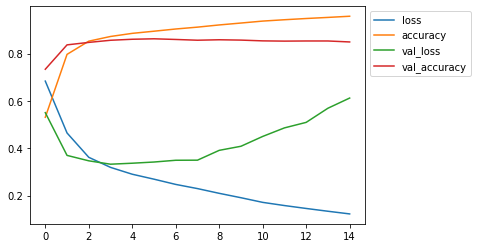

In [112]:
dff=pd.DataFrame(acc["64-512"].history)
dff.plot()
plt.legend(bbox_to_anchor=[1,1])
plt.show()

In [115]:
dff[dff["val_accuracy"]>0.85]

,loss,accuracy,val_loss,val_accuracy
3,0.319315,0.872290,0.332768,0.856278
4,0.290403,0.885485,0.336924,0.860553
5,0.269486,0.894557,0.341955,0.862503
6,0.247365,0.903886,0.349382,0.859698
7,0.229727,0.911753,0.349773,0.856483
...,...,...,...,...
9,0.191158,0.929078,0.408529,0.856996
10,0.171530,0.937321,0.450042,0.853747
11,0.158077,0.943016,0.486146,0.852687
12,0.145779,0.948198,0.509461,0.853302


In [117]:
tf.random.set_seed(100)
rnn_model=rnn(hidden=64)
rnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
rnn_history = rnn_model.fit(x_train,y_train,epochs=5,batch_size=512,validation_data=(x_val, y_val),verbose=1)


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 45, 200)           2000000   
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                67840     
_________________________________________________________________
dense_56 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 65        
Total params: 2,072,065
Trainable params: 2,072,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
229/229 [==============================] - 4s 11ms/step - loss: 0.6926 - accuracy: 0.5089 - val_los

In [118]:
print(rnn_model.evaluate(X_test, y_test))

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3385 - accuracy: 0.8557
[0.3384932577610016, 0.8557479381561279]


## 회고

- 적절한 문장 길이를 찾기 위해서 그래프를 그리는 과정을 다 거쳐서 가장 최적의 길이라고 생각하는 지점잡아서 패딩을 만들어서 넣어서 그런지 다른 하이퍼파라미터를 안맞춰도 85.5에 가까운 성능이 잘 나오는 것은 신기했다. 하지만 가장 긴 시퀀스의 길이를 지정하는 다른 좋은 방법도 있을 것 같다. 같은 조의 태원님과 이야기를 나누면서 제 사분위수를 뽑아서 확인해서 어디에서 자를지 결정하는 것도 간단하고 좋은 방법이라고 생각이 들었다.
- 불용어를 찾기 위해서 최다 빈도수를 찾아서 확인하는 과정에서 내가 일상적으로 사용하는 채팅 용어들이 일종에 자연어 전처리 대상이라는 것을 알게 되었다. 이렇게 일상적으로 사용하는 단어들을 통해서 긍정과 부정을 파악하는데 쓰이는 점이 흥미로웠다.
- 내가 만든 모델의 임베딩 벡터를 사용해서 단어유사도가 높은 단어를 뽑아보니 날것의 단어들이 많이 뽑혀서 재밌었다. 하트도 일종에 단어로 인지하는 것이 흥미로웠다. 요즘은 더 다양한 이모티콘도 일종에 단어로 생각되어질 수 있겠다는 생각을 했다. 이런 의미에서 앞에서 뽑았던 가설로 한 글자의 단어를 지우는 것을 고려했던 것은 다시 생각해볼 필요가 있다고 느꼈다. 시간이 지남에 따라 한개의 이모티콘이나 ㅋ같은 채팅 용어들도 일종에 감정을 표현하는 요소라는 생각이 들었다. 다만 정제가 아무래도 덜 되어서 상관 없는 단어들이 많이 뽑혀서 전처리의 중요성을 느꼈다.
- 사실 word2vec을 넣으면 바로 성능이 좋아질줄 알았다. 하지만 처음에는 오히려 처음에 내가 처음에 만든 모델보다 성능이 떨어져서 당황하니까 다른 조원분들이 하이퍼파라미터를 다시 튜닝해보기를 권하여서 튜닝을 거치니까 월등하게 성능이 좋아지게 되었다. 새로운 데이터나 pre-trained model을 추가하는 과정에서 하이퍼 파라미터를 하는 것을 잊지 말아야겠다.
